In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorboard import notebook

import keras.models
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras.layers import Dropout
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

2022-11-03 10:20:46.043492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_audio(file_name):
    audio_data, sample_rate = sf.read(file_name)
    return audio_data[::2]

In [3]:
def preprocess(file_path):
    wav = load_audio(file_path)
    wav = wav[:320000]
    zero_padding = tf.zeros([320000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    spectrogram = tfio.audio.spectrogram(
        wav, nfft=3072, window=3072, stride=1429)

    mel_spectrogram = tfio.audio.melscale(
        spectrogram, rate=16000, mels=224, fmin=0, fmax=8000)

    dbscale_mel_spectrogram = tfio.audio.dbscale(
        mel_spectrogram, top_db=120)

    freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=5)

    time_mask = tfio.audio.time_mask(freq_mask, param=5)
    time_mask = tf.expand_dims(time_mask, axis=2)
    return time_mask

In [4]:
def create_model(num_labels):
    vgg = VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
    
    for layer in vgg.layers:
        layer.trainable = False

    # Fully connected layers  
    x = Flatten()(vgg.output) 
    output = Dense(units = num_labels, activation ='softmax')(x)
    
    model = Model([vgg.input], [output])
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [5]:
def train_model(trainImagesX, trainY, testImagesX, testY, num_labels, batch_amt, epoch_amt, save):
    model = create_model(num_labels)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    model.fit( x=trainImagesX, y=trainY, validation_data=(testImagesX, testY),
        epochs=epoch_amt, batch_size=batch_amt, callbacks=[tensorboard_callback], verbose=False)
    
    if save:
        model.save("model")

    return model

In [6]:
def predict_file(file_name, model, label_encoder, latitude, longitude, date):
    image = preprocess(file_name)

    predicted_label = model.predict([image.numpy().reshape(1, 224, 224, 3)])
    classes_x = np.argmax(predicted_label, axis=1)
    prediction_class = labelencoder.inverse_transform(classes_x)
    return prediction_class

In [7]:
def process_images(df, inputPath):
    images = []
    for index_num, row in df.iterrows():
        images.append(preprocess(inputPath + row["primary_label"] + "/" + row["filename"]))
    return np.asarray(images).astype(np.float32)

In [8]:
def load_attributes(inputPath):
    cols = ["filename", "primary_label"]
    df = pd.read_csv(inputPath, skipinitialspace=True, usecols=cols)
    df = df.loc[df['primary_label'] <= "aldfly"]
    df = shuffle(df)
    df.reset_index(inplace=True, drop=True)
    return df

In [9]:
df = load_attributes("./Data/train_metadata.csv")

In [10]:
images = process_images(df, "./Data/Audio/")

2022-11-03 10:20:49.324612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
images = np.repeat(images,repeats=3,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


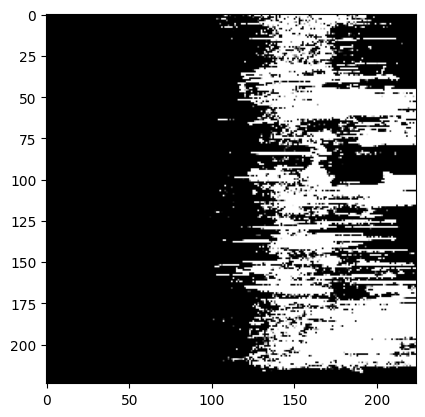

In [45]:
plt.imshow(images[28])
plt.show()

## images.shape

In [14]:
split = train_test_split(df, images, test_size=0.2, random_state=0)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
label_encoder = LabelEncoder()
trainY = to_categorical(label_encoder.fit_transform(trainAttrX["primary_label"]))
testY = to_categorical(label_encoder.fit_transform(testAttrX["primary_label"]))

In [15]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir=logs/fit --host localhost --port 8088

In [17]:
num_labels = trainY.shape[1]

#train_model(trainImagesX, trainY, testImagesX, testY, num_labels, 16, 3, True)

#model = keras.models.load_model("model")

#preds = model.predict([testImagesX, testAttrX])


In [18]:
prediction = predict_file("./Data/Audio/aldfly/XC477348.ogg", model, label_encoder,
                              42.0458, -79.441, "2019-05-27")
prediction

NameError: name 'model' is not defined